## LSWI Predictions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# imports
import pickle as pkl # pickle files
import numpy as np # good to have
import pandas as pd # dataframes
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
from statsmodels.tsa.stattools import grangercausalitytests # granger causality test for causality
from statsmodels.tsa.stattools import adfuller # augmented dickey-fuller test for stationarity
#import statsmodels.tsa.vector_ar.vecm as VAR # VAR model
from statsmodels.tsa.api import VAR # VAR model
import os
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib import pylab, mlab, pyplot
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.activations import sigmoid, tanh, softmax, relu, elu

from tabulate import tabulate

In [ ]:
jacob_path = '/content/drive/MyDrive/DS for Ag - Spring 24 (Time Series)'

base_path = jacob_path # just change this line
data_path = os.path.join(base_path, 'Spring 2024', 'Data')

In [ ]:
fname = 'p13_final_df_ind_imputed.pkl'

fpath = os.path.join(data_path, fname)

print(fpath)

/content/drive/MyDrive/DS for Ag - Spring 24 (Time Series)/Spring 2024/Data/p13_final_df_ind_imputed.pkl


## Loading Data and Initial Inspection

In [ ]:
# file name
fname = 'p13_final_df_ind_imputed.pkl'

fpath = os.path.join(data_path, fname)

# loads data and shows the column names
with open(fpath, 'rb') as fp:
    dat = pkl.load(fp)
    print(dat.keys())

Index(['TMAX', 'TMIN', 'TAVG', 'HAVG', 'VDEF', 'HDEG', 'CDEG', 'WSPD', 'ATOT',
       'RAIN', 'SAVG', 'BAVG', 'TR05', 'TR25', 'TR60', 'EVI', 'LSWI',
       'RAIN_7_Days', 'RAIN_14_Days', 'RAIN_21_Days', 'RAIN_28_Days'],
      dtype='object')


In [ ]:
dat.head()

,TMAX,TMIN,TAVG,HAVG,VDEF,HDEG,CDEG,WSPD,ATOT,RAIN,...,BAVG,TR05,TR25,TR60,EVI,LSWI,RAIN_7_Days,RAIN_14_Days,RAIN_21_Days,RAIN_28_Days
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-16,51.91,30.63,35.60,99.84,0.01,23.73,0.0,12.53,1.95,0.23,...,49.05,1.5728,1.5437,1.4708,0.1671,-0.2239,0.54,1.31,2.60,3.08
2000-03-17,44.02,31.91,38.90,99.32,0.06,27.03,0.0,4.99,3.44,0.40,...,43.58,1.5291,1.5439,1.4723,0.1700,-0.2250,0.93,1.64,2.42,3.48
2000-03-18,47.59,39.43,42.18,91.32,0.85,21.49,0.0,8.90,5.66,0.02,...,46.06,1.5287,1.5465,1.4685,0.1741,-0.2236,0.95,1.66,2.44,3.50
2000-03-19,60.55,37.21,46.12,67.95,4.29,16.12,0.0,11.10,23.28,0.00,...,48.53,1.5285,1.5431,1.4681,0.1782,-0.2200,0.95,1.66,2.44,3.50
2000-03-20,73.85,37.63,55.00,57.60,8.43,9.26,0.0,15.37,23.64,0.00,...,50.28,1.5416,1.5443,1.4706,0.1825,-0.2141,0.95,1.66,2.44,3.50


In [ ]:
dat.describe()

,TMAX,TMIN,TAVG,HAVG,VDEF,HDEG,CDEG,WSPD,ATOT,RAIN,...,BAVG,TR05,TR25,TR60,EVI,LSWI,RAIN_7_Days,RAIN_14_Days,RAIN_21_Days,RAIN_28_Days
count,7957.000000,7957.000000,7957.000000,7957.000000,7957.000000,7957.000000,7957.000000,7957.000000,7957.000000,7957.000000,...,7957.000000,7957.000000,7957.000000,7957.000000,7957.000000,7957.000000,7957.000000,7957.000000,7957.000000,7957.000000
mean,71.970528,47.000710,59.199021,69.455094,7.490613,10.449909,4.972646,10.708190,16.992348,0.051596,...,61.678698,2.094238,2.102325,2.295856,0.310289,-0.029326,0.361396,0.723280,1.086087,1.449627
std,18.701380,18.032937,17.840710,14.090712,5.690528,12.689145,6.991622,4.118791,7.781407,0.154229,...,16.623834,0.680976,0.730188,0.895388,0.134959,0.167339,0.481305,0.707108,0.895099,1.054537
min,16.430000,-3.800000,8.000000,27.470000,0.000000,0.000000,0.000000,2.220000,0.460000,0.000000,...,27.040000,1.330400,1.325900,1.310100,-0.085000,-1.370000,0.000000,0.000000,0.000000,0.000000
25%,58.750000,31.840000,44.960000,59.800000,3.080000,0.000000,0.000000,7.500000,11.470000,0.000000,...,46.720000,1.557000,1.544300,1.481200,0.196200,-0.158200,0.000000,0.170000,0.390000,0.630000
50%,74.570000,47.730000,61.000000,69.840000,6.180000,4.100000,0.000000,10.060000,16.870000,0.000000,...,62.420000,1.833483,1.796000,1.941500,0.278600,-0.049500,0.150000,0.540000,0.900000,1.250000
75%,87.440000,63.660000,74.680000,79.310000,10.430000,19.600000,10.280000,13.440000,23.730000,0.010000,...,76.420000,2.376500,2.406600,3.387700,0.423000,0.097600,0.560000,1.085000,1.560000,2.035000
max,113.540000,82.650000,96.820000,100.000000,26.250000,49.070000,26.080000,23.490000,32.210000,1.060000,...,93.090000,3.974800,3.927600,3.766400,0.666900,1.003000,3.310000,5.270000,6.650000,7.210000


from matplotlib import pyplot as plt
_df_0['TMAX'].plot(kind='hist', bins=20, title='TMAX')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['TMIN'].plot(kind='hist', bins=20, title='TMIN')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['TAVG'].plot(kind='hist', bins=20, title='TAVG')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['HAVG'].plot(kind='hist', bins=20, title='HAVG')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='TMAX', y='TMIN', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='TMIN', y='TAVG', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='TAVG', y='HAVG', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='HAVG', y='VDEF', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['TMAX'].plot(kind='line', figsize=(8, 4), title='TMAX')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['TMIN'].plot(kind='line', figsize=(8, 4), title='TMIN')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['TAVG'].plot(kind='line', figsize=(8, 4), title='TAVG')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['HAVG'].plot(kind='line', figsize=(8, 4), title='HAVG')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# check for missing values
dat.isna().sum()

TMAX            0
TMIN            0
TAVG            0
HAVG            0
VDEF            0
HDEG            0
CDEG            0
WSPD            0
ATOT            0
RAIN            0
SAVG            0
BAVG            0
TR05            0
TR25            0
TR60            0
EVI             0
LSWI            0
RAIN_7_Days     0
RAIN_14_Days    0
RAIN_21_Days    0
RAIN_28_Days    0
dtype: int64

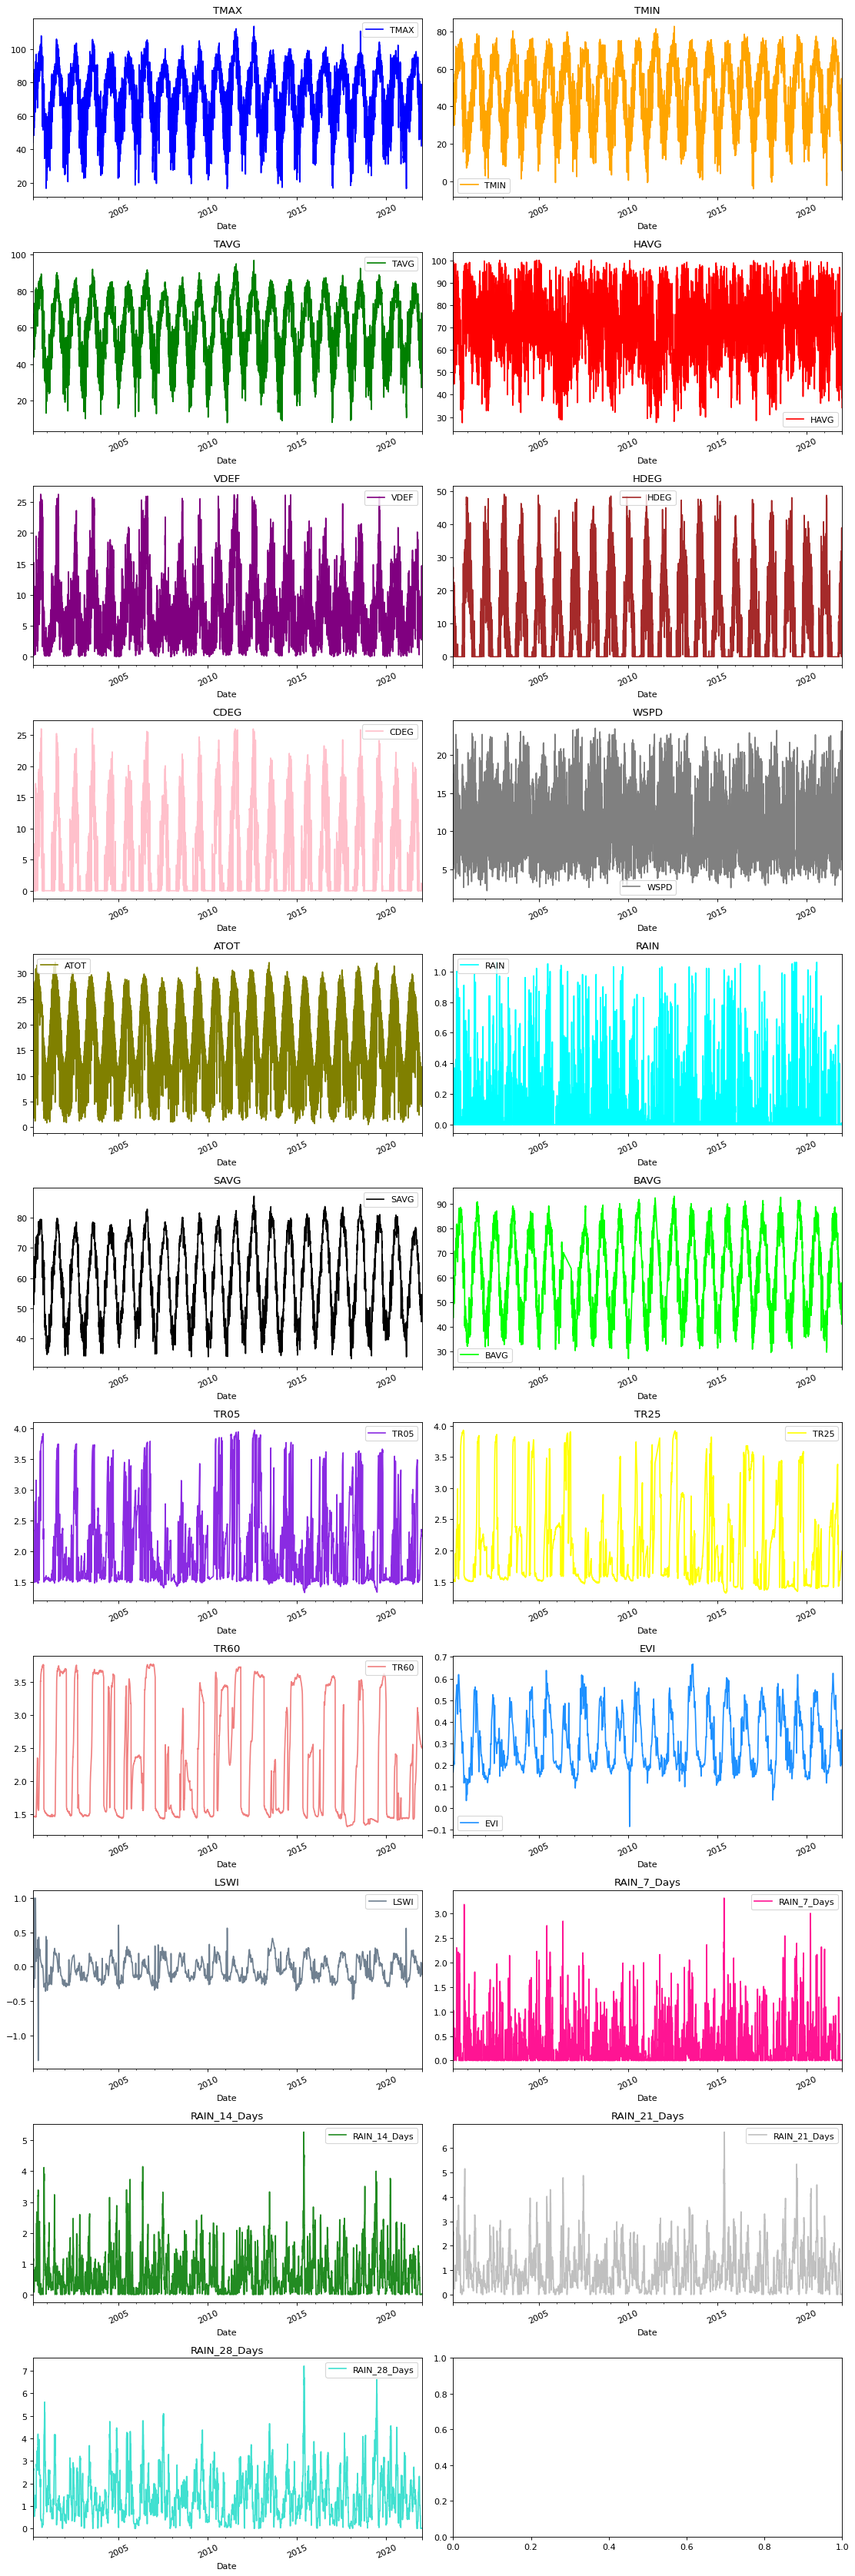

In [ ]:
# https://www.youtube.com/watch?v=TpQtD7ONfxQ
# 5:39

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'black', 'lime', 'blueviolet', 'yellow',
          'lightcoral', 'dodgerblue', 'slategray', 'deeppink', 'forestgreen', 'silver', 'turquoise']

def Vis(data):
  features = list(dat.select_dtypes(include = [np.number]).columns.values)
  feature_size = len(features)
  fig, axes = plt.subplots(
      nrows = int(np.ceil(feature_size/2)), ncols = 2, figsize = (14, feature_size*2), dpi = 80, facecolor = 'w', edgecolor = 'k'
  )
  for i in range(feature_size):
    key = features[i]
    c = colors[i % (len(colors))]
    t_data = data[key]
    t_data.head()
    ax = t_data.plot(
        ax = axes[i //2, i % 2],
        color = c,
        title = '{}'.format(key),
        rot = 25,
    )
    ax.legend([key])
  plt.tight_layout()

Vis(dat)

## Scaling

In [ ]:
scaler = MinMaxScaler() # make scaler object

scaled_data = scaler.fit_transform(dat) # fit the data

In [ ]:
# Convert back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=dat.columns, index = dat.index)

## Stationarity Test

In [ ]:
# Checking stationarity

for i in range(len(scaled_df.columns)):
  result = adfuller(scaled_df[scaled_df.columns[i]])

  if result[1] > 0.05:
    print('{} - Series is not stationary.'.format(scaled_df).columns[i])
  else:
    print('{} - Series is stationary.'.format(scaled_df.columns[i]))

TMAX - Series is stationary.
TMIN - Series is stationary.
TAVG - Series is stationary.
HAVG - Series is stationary.
VDEF - Series is stationary.
HDEG - Series is stationary.
CDEG - Series is stationary.
WSPD - Series is stationary.
ATOT - Series is stationary.
RAIN - Series is stationary.
SAVG - Series is stationary.
BAVG - Series is stationary.
TR05 - Series is stationary.
TR25 - Series is stationary.
TR60 - Series is stationary.
EVI - Series is stationary.
LSWI - Series is stationary.
RAIN_7_Days - Series is stationary.
RAIN_14_Days - Series is stationary.
RAIN_21_Days - Series is stationary.
RAIN_28_Days - Series is stationary.


## Feature Selection

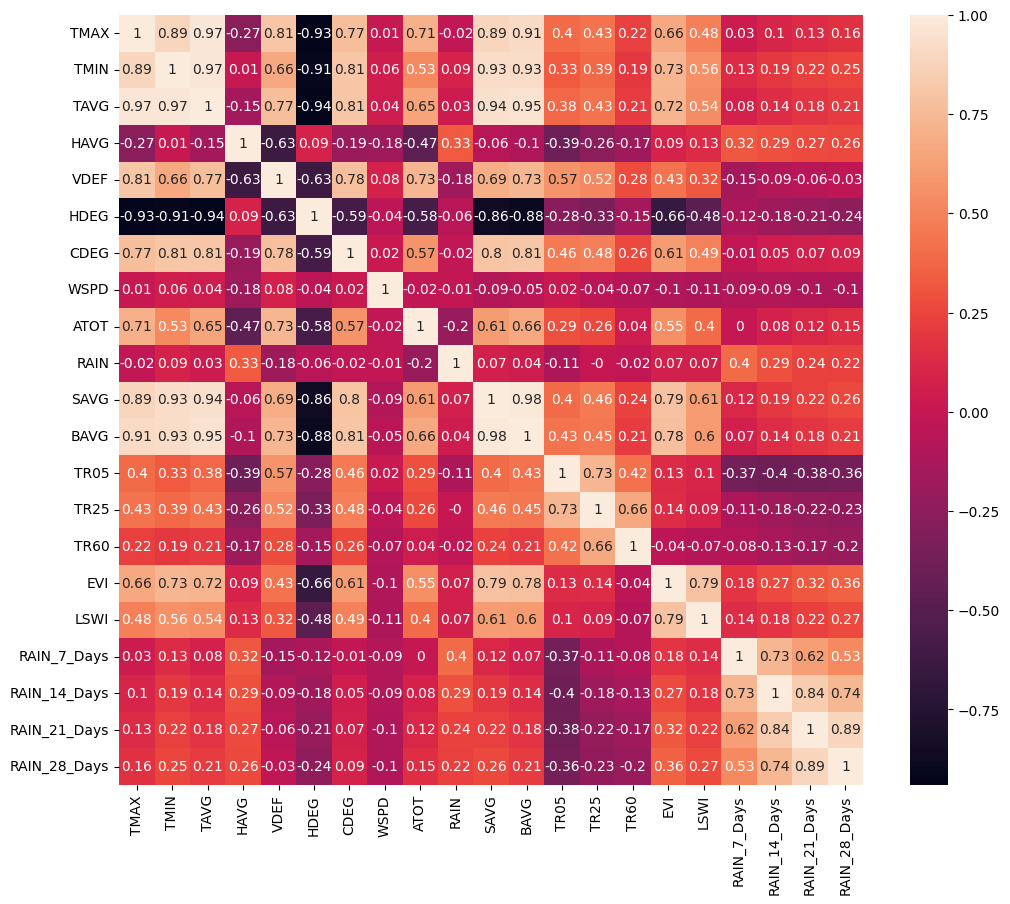

In [ ]:
matrix = scaled_df.corr()
rounded = matrix.round(2)

fig, ax = plt.subplots(figsize = (12, 10))
sns.heatmap(rounded, annot = True, cmap = 'rocket')
sns.set(font_scale = 0.6)

In [ ]:
lswi = rounded['LSWI']
lswi = lswi.drop('LSWI')
highest = lswi.nlargest(5)
highest

EVI     0.79
SAVG    0.61
BAVG    0.60
TMIN    0.56
TAVG    0.54
Name: LSWI, dtype: float64

using a max_lag of 10, it captures a more complex dynamic in the relationships between variables. By considering potential causal influences up to a lag of 10 time periods, we are accounting for the possibility that the effects of one variable on another may not be immediately apparent but might manifest with a delay for LSWI.

In [ ]:
max_lags = 10
y = 'LSWI'

In [ ]:
# https://www.youtube.com/watch?v=TpQtD7ONfxQ

from warnings import simplefilter
simplefilter(action = 'ignore', category = FutureWarning)

for i in range(len(scaled_df.columns) - 1):
  results = grangercausalitytests(scaled_df[[y, scaled_df.columns[i+1]]], max_lags, verbose = False)
  p_values = [round(results[i+1][0]['ssr_ftest'][1], 4) for i in range(max_lags)]
  print('Column - {} : P_Values - {}'.format(scaled_df.columns[i+1], p_values))

Column - TMIN : P_Values - [0.0, 0.0, 0.0, 0.0, 0.0002, 0.0, 0.0, 0.0, 0.0, 0.0]
Column - TAVG : P_Values - [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Column - HAVG : P_Values - [0.0, 0.0002, 0.3604, 0.4338, 0.8429, 0.8298, 0.9214, 0.7332, 0.4348, 0.4532]
Column - VDEF : P_Values - [0.0016, 0.0, 0.03, 0.0002, 0.2989, 0.0229, 0.1656, 0.0002, 0.0, 0.0046]
Column - HDEG : P_Values - [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Column - CDEG : P_Values - [0.6299, 0.0, 0.0389, 0.0, 0.2639, 0.0166, 0.1728, 0.0, 0.0, 0.0011]
Column - WSPD : P_Values - [0.0009, 0.0001, 0.2644, 0.9501, 0.0118, 0.0821, 0.0471, 0.2227, 0.2073, 0.4864]
Column - ATOT : P_Values - [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Column - RAIN : P_Values - [0.0478, 0.1847, 0.638, 0.7948, 0.1343, 0.2428, 0.2759, 0.2671, 0.1045, 0.0656]
Column - SAVG : P_Values - [0.0002, 0.0, 0.0, 0.0, 0.0002, 0.0, 0.0, 0.0, 0.0, 0.0]
Column - BAVG : P_Values - [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Column 

## Splitting Data

In [ ]:
df_input = scaled_df[['LSWI', 'TMIN', 'TAVG', 'HDEG', 'ATOT', 'SAVG', 'BAVG', 'TR60', 'RAIN_28_Days']]

In [ ]:
# Specify the cut-off point
cut_off_date = '2020-01-01' # using the last two years (2020, 2021) as the test data

# Training data
training = df_input.loc[df_input.index < cut_off_date] # (2000 - 2019)

# Select all rows on and after the cut-off date
test = df_input.loc[df_input.index >= cut_off_date] # (2020 - 2021)
#test.drop(columns=['LSWI'], inplace=True)

In [ ]:
test

,LSWI,TMIN,TAVG,HDEG,ATOT,SAVG,BAVG,TR60,RAIN_28_Days
Date,,,,,,,,,
2020-01-01,0.475769,0.391903,0.402387,0.439984,0.358110,0.168836,0.192279,0.330945,0.029820
2020-01-02,0.476359,0.495431,0.437514,0.354799,0.356850,0.220900,0.271764,0.255913,0.029820
2020-01-03,0.477244,0.379526,0.373114,0.475443,0.368504,0.220900,0.257835,0.197126,0.029820
2020-01-04,0.478466,0.324002,0.331119,0.539026,0.378583,0.180550,0.208933,0.150511,0.028433
2020-01-05,0.479983,0.369462,0.389327,0.445690,0.386772,0.188546,0.213929,0.117901,0.028433
...,...,...,...,...,...,...,...,...,...
2021-12-23,0.538348,0.453210,0.451025,0.322600,0.280000,0.272778,0.312339,0.492896,0.002774
2021-12-24,0.547577,0.628803,0.648728,0.006114,0.219843,0.305690,0.373505,0.490982,0.002774
2021-12-25,0.559756,0.575709,0.570480,0.129611,0.287874,0.337672,0.423921,0.489150,0.002774


## Finding Optial Lag Values

In [ ]:
lags = [2, 10, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365]

model = VAR(training, freq = 'D')

for i in lags:
  results = model.fit(i + 1)
  print("Order: ", i+1)
  print("AIC: ", results.aic)
  print("BIC: ", results.bic)

Order:  3
AIC:  -65.86113473481346
BIC:  -65.62103981556574
Order:  11
AIC:  -66.83228174250519
BIC:  -65.9739877202964
Order:  31
AIC:  -67.39972766217778
BIC:  -64.99079899648774
Order:  61
AIC:  -67.33633140408435
BIC:  -62.587589432181474
Order:  91
AIC:  -67.1706662395612
BIC:  -60.065306866745935
Order:  121
AIC:  -67.09003563551258
BIC:  -57.611060188224876
Order:  151
AIC:  -66.83497034985832
BIC:  -54.965182483013265
Order:  181
AIC:  -66.58659107226963
BIC:  -52.30859361407374
Order:  211
AIC:  -66.3657242900165
BIC:  -49.6619160227291
Order:  241
AIC:  -66.18858982908407
BIC:  -47.041162204143674
Order:  271
AIC:  -66.01992044172263
BIC:  -44.41085422761243
Order:  301
AIC:  -66.02654000184356
BIC:  -41.9376018630224
Order:  331
AIC:  -65.9126589388559
BIC:  -39.3253979440325
Order:  366
AIC:  -65.86870616540557
BIC:  -36.34311999279033


In [ ]:
model.select_order(365).summary()

,AIC,BIC,FPE,HQIC
0,-41.16,-41.15,1.334e-18,-41.16
1,-61.58,-61.49,1.811e-27,-61.54
2,-64.76,-64.59,7.522e-29,-64.70
3,-66.54,-66.29,1.262e-29,-66.46
4,-66.72,-66.39,1.055e-29,-66.61
5,-66.90,-66.49,8.805e-30,-66.76
6,-66.97,-66.48,8.235e-30,-66.80
7,-66.99,-66.41,8.103e-30,-66.79
8,-67.14,-66.48,6.963e-30,-66.91
9,-67.19,-66.45,6.632e-30,-66.93


## VAR Models
HQIC and BIC: 11  
AIC and FPE: 30  

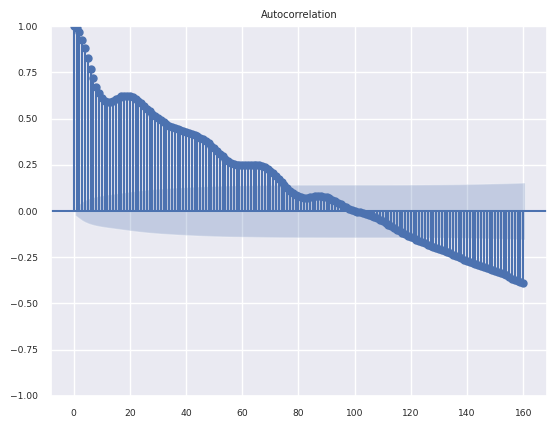

<Figure size 2000x1000 with 0 Axes>

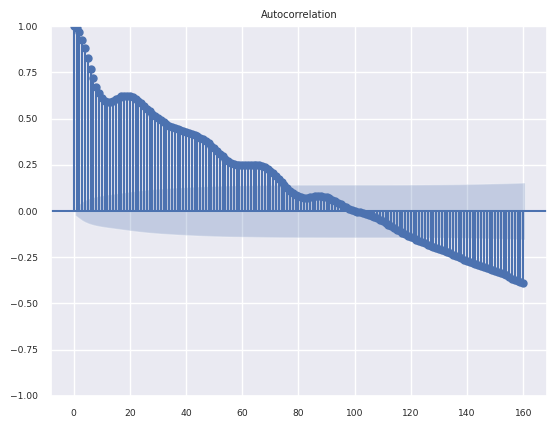

In [ ]:
# https://medium.com/@krzysztofdrelczuk/acf-autocorrelation-function-simple-explanation-with-python-example-492484c32711

from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(20,10))
plot_acf(training['LSWI'], lags=160)

### Lag 11

In [ ]:
model = VAR(training, freq = 'D')
results = model.fit(11)

In [ ]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 26, Mar, 2024
Time:                     07:53:35
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -65.9740
Nobs:                     7219.00    HQIC:                  -66.5370
Log likelihood:           149941.    FPE:                9.44313e-30
AIC:                     -66.8323    Det(Omega_mle):     8.34341e-30
--------------------------------------------------------------------
Results for equation LSWI
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.001346         0.000198            6.784           0.000
L1.LSWI                  3.213557         0.010613          302.808           0.000
L1.TMIN                 -0.000222         0.00023

In [ ]:
# Generate forecasts
forecast = results.forecast(training.values, steps=12)  # Adjust the steps as needed

# Convert forecast array to DataFrame with proper date index
forecast_index = pd.date_range(start=training.index[-1], periods=13, freq='D')[1:]  # Adjusted to include all forecasted periods
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=training.columns)

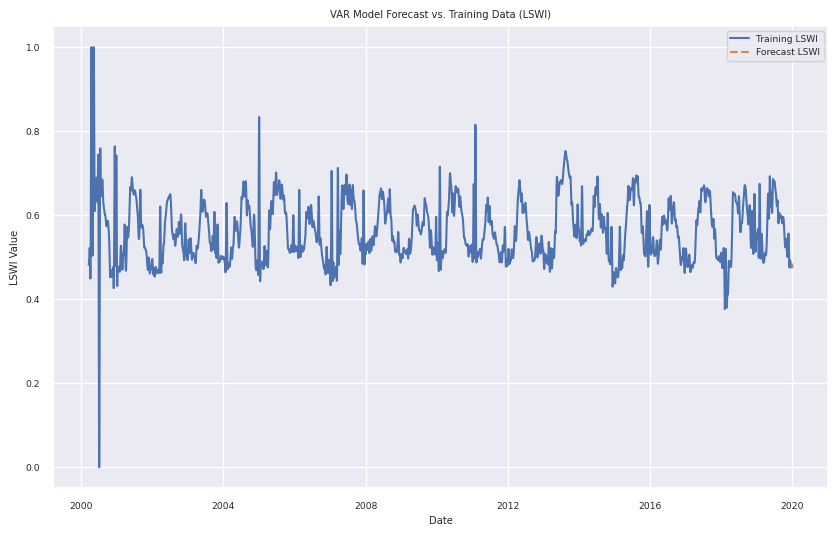

In [ ]:
# Plotting only LSWI data
plt.figure(figsize=(10, 6))
plt.plot(training.index, training['LSWI'], label='Training LSWI')
plt.plot(forecast_df.index, forecast_df['LSWI'], label='Forecast LSWI', linestyle='--')

plt.title('VAR Model Forecast vs. Training Data (LSWI)')
plt.xlabel('Date')
plt.ylabel('LSWI Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
forecast = results.forecast(training.values, steps=len(test))  # Forecast the same length as the test data

# Convert forecast array to DataFrame with proper date index
forecast_index = pd.date_range(start=test.index[0], periods=len(test), freq='D')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=test.columns)

In [ ]:
mse = mean_squared_error(test['LSWI'], forecast_df['LSWI'])
mse

0.003423836287149235

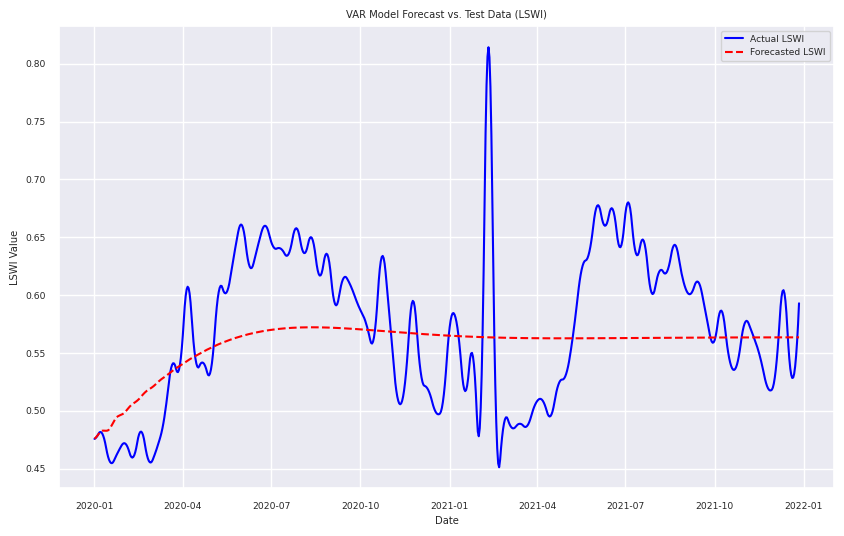

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['LSWI'], label='Actual LSWI', color='blue')
plt.plot(forecast_df.index, forecast_df['LSWI'], label='Forecasted LSWI', linestyle='--', color='red')

plt.title('VAR Model Forecast vs. Test Data (LSWI)')
plt.xlabel('Date')
plt.ylabel('LSWI Value')
plt.legend()
plt.grid(True)
plt.show()

### Lag 30

In [ ]:
model = VAR(training, freq = 'D')
results = model.fit(30)

In [ ]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, Mar, 2024
Time:                     16:44:58
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -65.0653
Nobs:                     7200.00    HQIC:                  -66.5944
Log likelihood:           153119.    FPE:                5.37273e-30
AIC:                     -67.3965    Det(Omega_mle):     3.85282e-30
--------------------------------------------------------------------
Results for equation LSWI
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.001402         0.000199            7.050           0.000
L1.LSWI                  3.282400         0.012023          273.008           0.000
L1.TMIN                 -0.000252         0.00019

In [ ]:
# Generate forecasts
forecast = results.forecast(training.values, steps=12)  # Adjust the steps as needed

# Convert forecast array to DataFrame with proper date index
forecast_index = pd.date_range(start=training.index[-1], periods=13, freq='D')[1:]  # Adjusted to include all forecasted periods
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=training.columns)

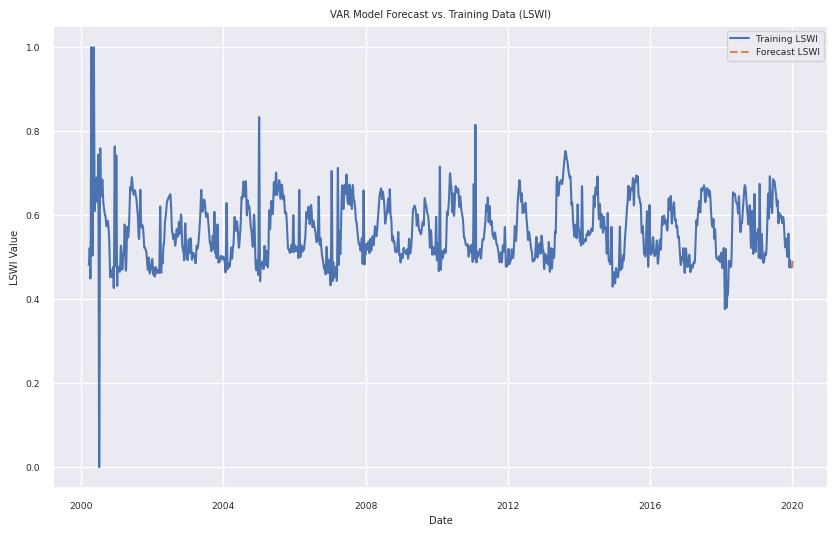

In [ ]:
# Plotting only LSWI data
plt.figure(figsize=(10, 6))
plt.plot(training.index, training['LSWI'], label='Training LSWI')
plt.plot(forecast_df.index, forecast_df['LSWI'], label='Forecast LSWI', linestyle='--')

plt.title('VAR Model Forecast vs. Training Data (LSWI)')
plt.xlabel('Date')
plt.ylabel('LSWI Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
forecast = results.forecast(training.values, steps=len(test))  # Forecast the same length as the test data

# Convert forecast array to DataFrame with proper date index
forecast_index = pd.date_range(start=test.index[0], periods=len(test), freq='D')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=test.columns)

In [ ]:
mse = mean_squared_error(test['LSWI'], forecast_df['LSWI'])
mse

0.002664982105875122

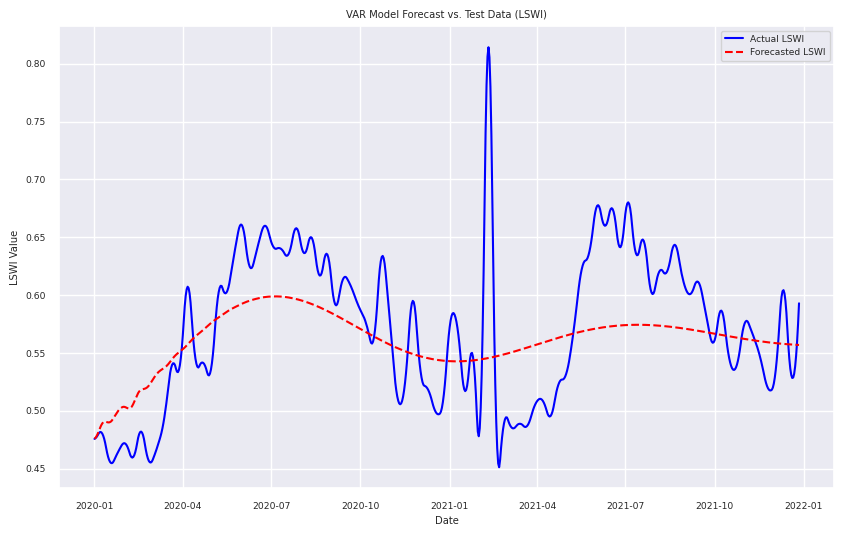

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['LSWI'], label='Actual LSWI', color='blue')
plt.plot(forecast_df.index, forecast_df['LSWI'], label='Forecasted LSWI', linestyle='--', color='red')

plt.title('VAR Model Forecast vs. Test Data (LSWI)')
plt.xlabel('Date')
plt.ylabel('LSWI Value')
plt.legend()
plt.grid(True)
plt.show()

### Lag 365

In [ ]:
model = VAR(training, freq = 'D')
results = model.fit(365)

In [ ]:
results.summary()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Generate forecasts
forecast = results.forecast(training.values, steps=12)  # Adjust the steps as needed

# Convert forecast array to DataFrame with proper date index
forecast_index = pd.date_range(start=training.index[-1], periods=13, freq='D')[1:]  # Adjusted to include all forecasted periods
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=training.columns)

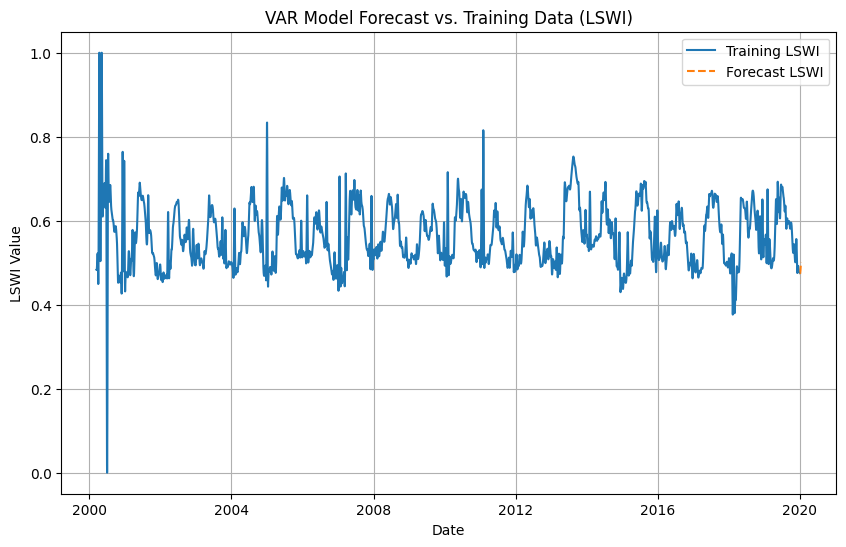

In [ ]:
# Plotting only LSWI data
plt.figure(figsize=(10, 6))
plt.plot(training.index, training['LSWI'], label='Training LSWI')
plt.plot(forecast_df.index, forecast_df['LSWI'], label='Forecast LSWI', linestyle='--')

plt.title('VAR Model Forecast vs. Training Data (LSWI)')
plt.xlabel('Date')
plt.ylabel('LSWI Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
forecast = results.forecast(training.values, steps=len(test))  # Forecast the same length as the test data

# Convert forecast array to DataFrame with proper date index
forecast_index = pd.date_range(start=test.index[0], periods=len(test), freq='D')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=test.columns)

In [ ]:
mse = mean_squared_error(test['LSWI'], forecast_df['LSWI'])
np.sqrt(mse)

0.04985233489949545

In [ ]:
from tabulate import tabulate

def metrics (true_val, pred_val):

    true_val = true_val.values.flatten()  # Convert DataFrame column to numpy array
    pred_val = pred_val.values.flatten()  # Convert DataFrame column to numpy array

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(true_val, pred_val)

    # Mean Squared Error (MSE)
    mse = mean_squared_error(true_val, pred_val)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Mean Absolute Percentage Error (MAPE)
    mask = true_val != 0
    mape = np.mean(np.abs((true_val[mask] - pred_val[mask]) / true_val[mask])) * 100

    # r squared
    rsq = r2_score(true_val, pred_val)

    table = [["MAE", mae], ["MSE", mse], ["RMSE", rmse], ["MAPE", mape], ["R2", rsq]]

    return table


In [ ]:
from tabulate import tabulate

test_metrics = metrics(test['LSWI'], forecast_df['LSWI'])

print(tabulate(test_metrics))

----  ----------
MAE   0.035337
MSE   0.00248526
RMSE  0.0498523
MAPE  6.12774
R2    0.415681
----  ----------


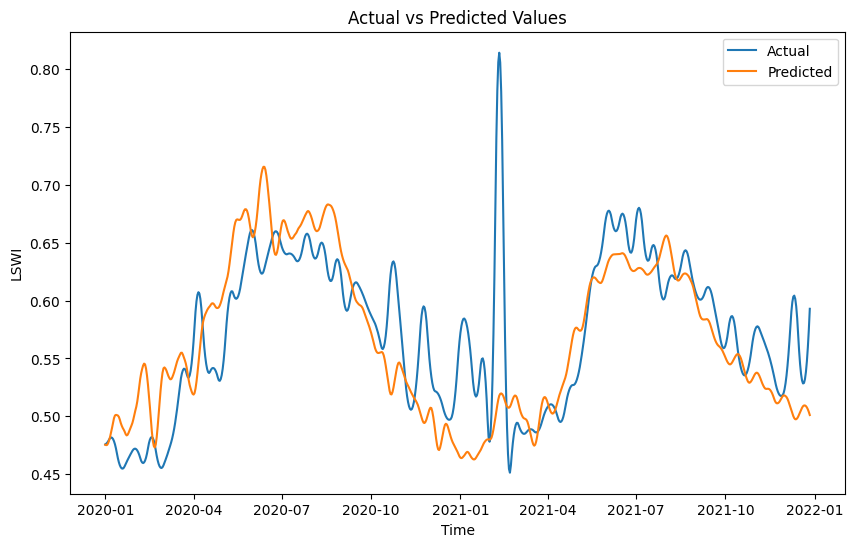

In [ ]:
index_test = test.index

plt.figure(figsize=(10, 6))
plt.plot(index_test, test[['LSWI']], label='Actual')
plt.plot(index_test, forecast_df[['LSWI']], label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('LSWI')
plt.legend()
plt.show()

## LSTM

In [ ]:
# Specify the cut-off point
cut_off_date1 = '2020-01-01' # using the last two years (2020, 2021) as the test data
cut_off_date2 = '2018-01-01'

# Training data
training = df_input.loc[df_input.index < cut_off_date2] # (2000 - 2018)

# Validation data
validation = df_input[(df_input.index >= cut_off_date2) & (df_input.index < cut_off_date1)]  # (2018 - 2019)

# Select all rows on and after the cut-off date
test = df_input.loc[df_input.index >= cut_off_date1] # (2020 - 2021)

Xtrain, Ytrain = training[['TMIN', 'TAVG', 'HDEG', 'ATOT', 'SAVG', 'BAVG', 'TR60', 'RAIN_28_Days']], training[['LSWI']]
Xval, Yval = validation[['TMIN', 'TAVG', 'HDEG', 'ATOT', 'SAVG', 'BAVG', 'TR60', 'RAIN_28_Days']], validation[['LSWI']]
Xtest, Ytest = test[['TMIN', 'TAVG', 'HDEG', 'ATOT', 'SAVG', 'BAVG', 'TR60', 'RAIN_28_Days']], test[['LSWI']]

In [ ]:
# Convert input data to numpy arrays
Xtrain = np.array(Xtrain)
Xval = np.array(Xval)
Xtest = np.array(Xtest)

# Reshape input data to have the shape (number_of_samples, 1, number_of_features)
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], 1, Xtrain.shape[1]))
Xval = np.reshape(Xval, (Xval.shape[0], 1, Xval.shape[1]))
Xtest = np.reshape(Xtest, (Xtest.shape[0], 1, Xtest.shape[1]))

In [ ]:
# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(units=50, input_shape=(1, 8)))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
history = model.fit(Xtrain, Ytrain, epochs=10, batch_size=32, validation_data=(Xval, Yval))

# Evaluate the model on test data
loss = model.evaluate(Xtest, Ytest)
print("Test Loss:", loss)

Epoch 1/10
204/204 [==============================] - 5s 8ms/step - loss: 0.0332 - val_loss: 0.0036
Epoch 2/10
204/204 [==============================] - 1s 5ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 3/10
204/204 [==============================] - 1s 3ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 4/10
204/204 [==============================] - 1s 3ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 5/10
204/204 [==============================] - 1s 3ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 6/10
204/204 [==============================] - 1s 3ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 7/10
204/204 [==============================] - 1s 3ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 8/10
204/204 [==============================] - 1s 3ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 9/10
204/204 [==============================] - 1s 3ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 10/10
23/23 [==============================] - 0s 2ms/step - loss: 0.0021
Test Loss: 0.0021011

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                11800     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11851 (46.29 KB)
Trainable params: 11851 (46.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

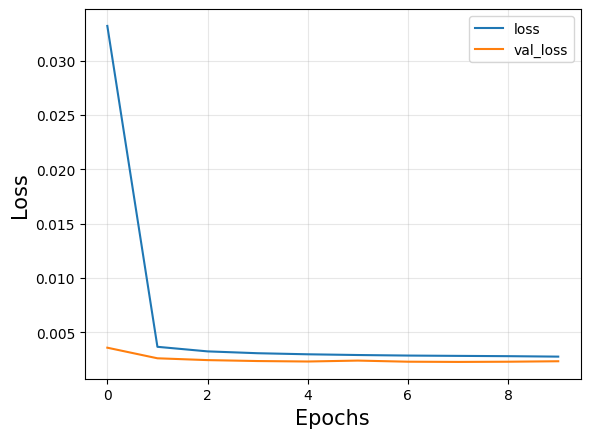

In [ ]:
plt.plot(history.epoch, history.history['loss'], label = "loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [ ]:
lswipred = model.predict(Xtest)

23/23 [==============================] - 1s 3ms/step


In [ ]:
lstm_pred = pd.DataFrame(lswipred, columns=['LSWI_pred'])

In [ ]:
lstm_pred.shape, lstm_pred.dtypes, Ytest.shape, Ytest.dtypes

((727, 1),
 LSWI_pred    float32
 dtype: object,
 (727, 1),
 LSWI    float64
 dtype: object)

In [ ]:
# mse for evipred
mse = mean_squared_error(Ytest, lstm_pred)
np.sqrt(mse)

0.045838260543056814

In [ ]:
test_metrics = metrics(Ytest, lstm_pred)
#test_metrics
print(tabulate(test_metrics))

----  ----------
MAE   0.0330665
MSE   0.00210115
RMSE  0.0458383
MAPE  5.76908
R2    0.505991
----  ----------


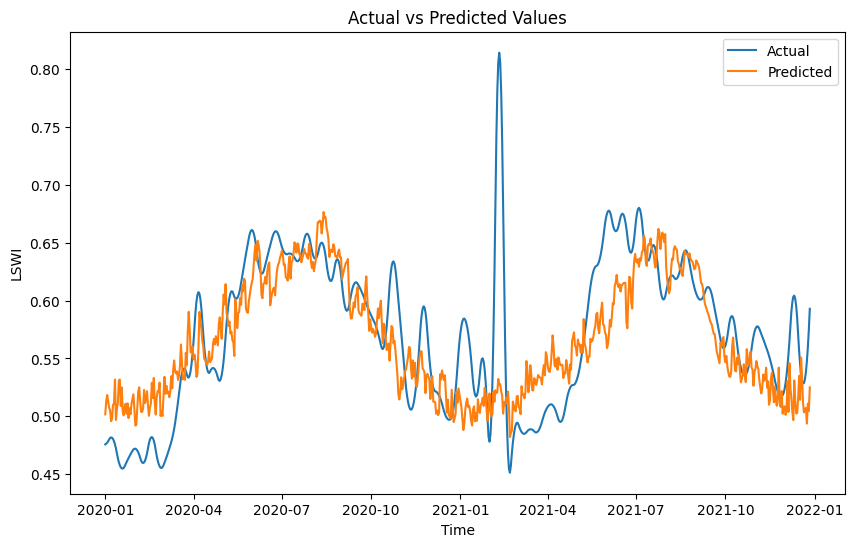

In [ ]:
index_test = test.index

plt.figure(figsize=(10, 6))
plt.plot(index_test, Ytest, label='Actual')
plt.plot(index_test, lswipred, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('LSWI')
plt.legend()
plt.show()

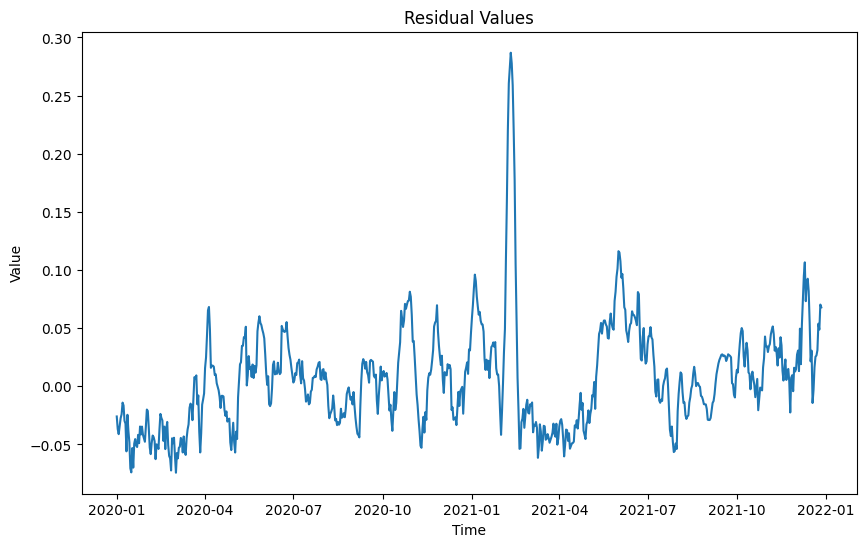

In [ ]:
# calculate residuals
residuals = [Ytest-lswipred]

# graph residuals
plt.figure(figsize=(10, 6))
plt.plot(index_test, residuals[0])
plt.title('Residual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

## Grid Search LSTM

In [ ]:
import itertools

learning_rate = [0.0001,0.00001]
n_neurons = [5,10,15]
n_epochs = [15, 20]
activation_functions = [sigmoid,softmax, 'leaky_relu']
regularization_terms = [None, l1(0.01), l2(0.01)]  # Adjust regularization strengths as needed

hyper_para = (learning_rate, n_neurons, n_epochs, activation_functions, regularization_terms)
hyper_para_grid = tuple(itertools.product(*hyper_para, repeat=1))
print(len(hyper_para_grid))
for learning_rate, n_neurons, n_epochs, activation_functions, regularization_terms in hyper_para_grid:
  print('lr',learning_rate, 'n_neurons', n_neurons,'n_epochs', n_epochs, 'activation_functions', activation_functions, 'regularization_terms', regularization_terms)


108
lr 0.0001 n_neurons 5 n_epochs 15 activation_functions <function sigmoid at 0x79b0bde73400> regularization_terms None
lr 0.0001 n_neurons 5 n_epochs 15 activation_functions <function sigmoid at 0x79b0bde73400> regularization_terms <keras.src.regularizers.L1 object at 0x79accc366320>
lr 0.0001 n_neurons 5 n_epochs 15 activation_functions <function sigmoid at 0x79b0bde73400> regularization_terms <keras.src.regularizers.L2 object at 0x79acc0671450>
lr 0.0001 n_neurons 5 n_epochs 15 activation_functions <function softmax at 0x79b0bde724d0> regularization_terms None
lr 0.0001 n_neurons 5 n_epochs 15 activation_functions <function softmax at 0x79b0bde724d0> regularization_terms <keras.src.regularizers.L1 object at 0x79accc366320>
lr 0.0001 n_neurons 5 n_epochs 15 activation_functions <function softmax at 0x79b0bde724d0> regularization_terms <keras.src.regularizers.L2 object at 0x79acc0671450>
lr 0.0001 n_neurons 5 n_epochs 15 activation_functions leaky_relu regularization_terms None
lr 0

In [ ]:
train_loss_grid, val_loss_grid = list(), list()
best_params = []

def fit_lstm_grid(batch_size):
  min_val_loss = 999
  current_val_loss = 0

  for learning_rate, n_neurons, n_epochs, activation_functions, regularization_terms in hyper_para_grid:
    print('lr',learning_rate, 'n_neurons', n_neurons,'n_epochs', n_epochs, 'activation_functions', activation_functions, 'regularization_terms', regularization_terms)
    model = Sequential()
    model.add(LSTM(n_neurons,return_sequences=False))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=learning_rate),metrics=['accuracy'])

    # fit model
    lstm_model = model.fit(Xtrain,Ytrain, epochs=n_epochs, batch_size=batch_size, validation_data=(Xval, Yval))
    current_val_loss = lstm_model.history['val_loss'][-1]

    if current_val_loss < min_val_loss:
      min_val_loss = current_val_loss
      best_params = [learning_rate, n_neurons, n_epochs, activation_functions, regularization_terms]
      print('best_params',best_params)

  return best_params

In [ ]:
def run_lstm_grid():
  n_batch = 100
  best_params = fit_lstm_grid(n_batch)
  return best_params

In [ ]:
best_params = run_lstm_grid()


lr 0.0001 n_neurons 5 n_epochs 15 activation_functions <function sigmoid at 0x79b0bde73400> regularization_terms None
Epoch 1/15
65/65 [==============================] - 3s 14ms/step - loss: 0.6824 - accuracy: 3.0769e-04 - val_loss: 0.6806 - val_accuracy: 0.0000e+00
Epoch 2/15
65/65 [==============================] - 0s 4ms/step - loss: 0.6820 - accuracy: 3.0769e-04 - val_loss: 0.6802 - val_accuracy: 0.0000e+00
Epoch 3/15
65/65 [==============================] - 0s 4ms/step - loss: 0.6818 - accuracy: 3.0769e-04 - val_loss: 0.6800 - val_accuracy: 0.0000e+00
Epoch 4/15
65/65 [==============================] - 0s 4ms/step - loss: 0.6817 - accuracy: 3.0769e-04 - val_loss: 0.6799 - val_accuracy: 0.0000e+00
Epoch 5/15
65/65 [==============================] - 0s 4ms/step - loss: 0.6816 - accuracy: 3.0769e-04 - val_loss: 0.6798 - val_accuracy: 0.0000e+00
Epoch 6/15
65/65 [==============================] - 0s 4ms/step - loss: 0.6815 - accuracy: 3.0769e-04 - val_loss: 0.6797 - val_accuracy: 0.00

In [ ]:
print(best_params)

[0.0001, 10, 20, <function softmax at 0x79b0bde724d0>, <keras.src.regularizers.L1 object at 0x79accc366320>]


## Hyperparameter Tuned

In [ ]:
learning_rate = 0.0001
n_neurons = 10
n_epochs = 20
act_func = "softmax"
reg_term = l1(0.01)

model = Sequential()

model.add(LSTM(units = n_neurons, input_shape=(1, 8), return_sequences=True))
model.add(LSTM(units= 5, return_sequences = True))  # Second LSTM layer
model.add(LSTM(units= 2))

model.add(Dense(units = 1, kernel_regularizer=reg_term)) #activation=act_func,

# Compile the model
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Print model summary
model.summary()

# Fit the model
model.fit(Xtrain, Ytrain, epochs=n_epochs, batch_size=32)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 10)             760       
                                                                 
 lstm_3 (LSTM)               (None, 1, 5)              320       
                                                                 
 lstm_4 (LSTM)               (None, 2)                 64        
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 1147 (4.48 KB)
Trainable params: 1147 (4.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
204/204 [==============================] - 6s 4ms/step - loss: 0.3209
Epoch 2/20
204/204 [==============================] - 1s 5ms/step - loss:

In [ ]:
lswipred = model.predict(Xtest)

23/23 [==============================] - 1s 2ms/step


In [ ]:
lstm_pred = pd.DataFrame(lswipred, columns=['LSWI_pred'])

In [ ]:
test_metrics = metrics(Ytest, lstm_pred)
#test_metrics
print(tabulate(test_metrics))

----  ---------
MAE   0.0357829
MSE   0.0027
RMSE  0.0519615
MAPE  6.11864
R2    0.365192
----  ---------


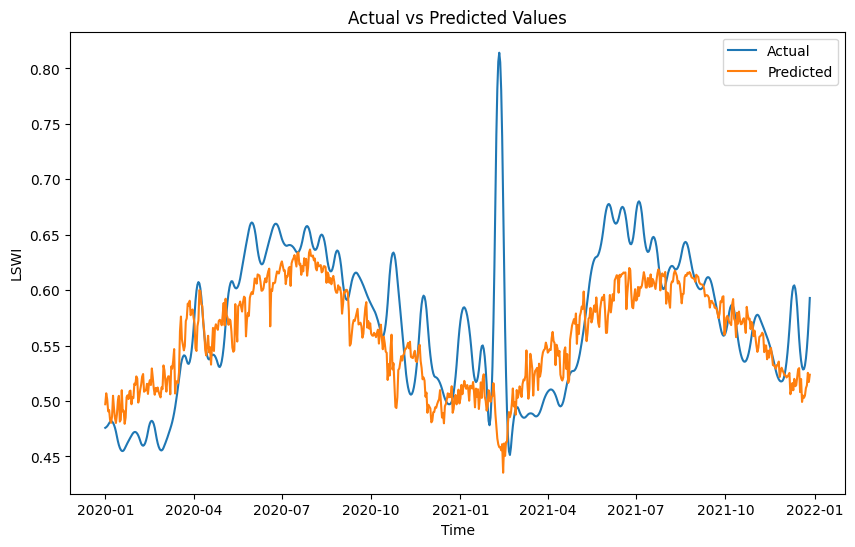

In [ ]:
index_test = test.index

plt.figure(figsize=(10, 6))
plt.plot(index_test, Ytest, label='Actual')
plt.plot(index_test, lswipred, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('LSWI')
plt.legend()
plt.show()

## Edited Hyperparameters

In [ ]:
learning_rate = 0.01
n_neurons = 50
n_epochs = 20
act_func = "softmax"
reg_term = l2(0.01)

model = Sequential()

model.add(LSTM(units = n_neurons, input_shape=(1, 8), return_sequences=True))
model.add(LSTM(units= 5, return_sequences = True))  # Second LSTM layer
model.add(LSTM(units= 2))

model.add(Dense(units = 1, kernel_regularizer=reg_term)) #activation=act_func,

# Compile the model
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Print model summary
model.summary()

# Fit the model
model.fit(Xtrain, Ytrain, epochs=n_epochs, batch_size=32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             11800     
                                                                 
 lstm_1 (LSTM)               (None, 1, 5)              1120      
                                                                 
 lstm_2 (LSTM)               (None, 2)                 64        
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 12987 (50.73 KB)
Trainable params: 12987 (50.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
204/204 [==============================] - 7s 5ms/step - loss: 0.0234
Epoch 2/20
204/204 [==============================] - 1s 7ms/step - los

In [ ]:

lstm_train = pd.DataFrame(model.predict(Xtrain), columns=['LSWI_train'])

204/204 [==============================] - 1s 6ms/step


In [ ]:
train_metrics = metrics(Ytrain, lstm_train)

print(tabulate(train_metrics))

----  ----------
MAE   0.0320586
MSE   0.00252865
RMSE  0.0502857
MAPE  6.87712
R2    0.499868
----  ----------


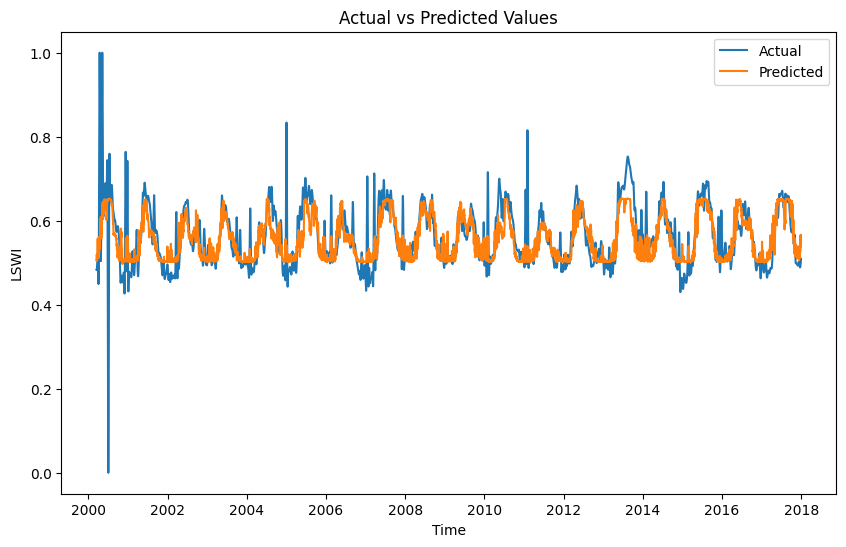

In [ ]:
index_train = training.index

plt.figure(figsize=(10, 6))
plt.plot(index_train, Ytrain, label='Actual')
plt.plot(index_train, lstm_train, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('LSWI')
plt.legend()
plt.show()

In [ ]:
lswipred = model.predict(Xtest)

23/23 [==============================] - 0s 3ms/step


In [ ]:
lstm_pred = pd.DataFrame(lswipred, columns=['LSWI_pred'])

In [ ]:
test_metrics = metrics(Ytest, lstm_pred)
#test_metrics
print(tabulate(test_metrics))

----  ----------
MAE   0.0320701
MSE   0.00193292
RMSE  0.043965
MAPE  5.55751
R2    0.545542
----  ----------


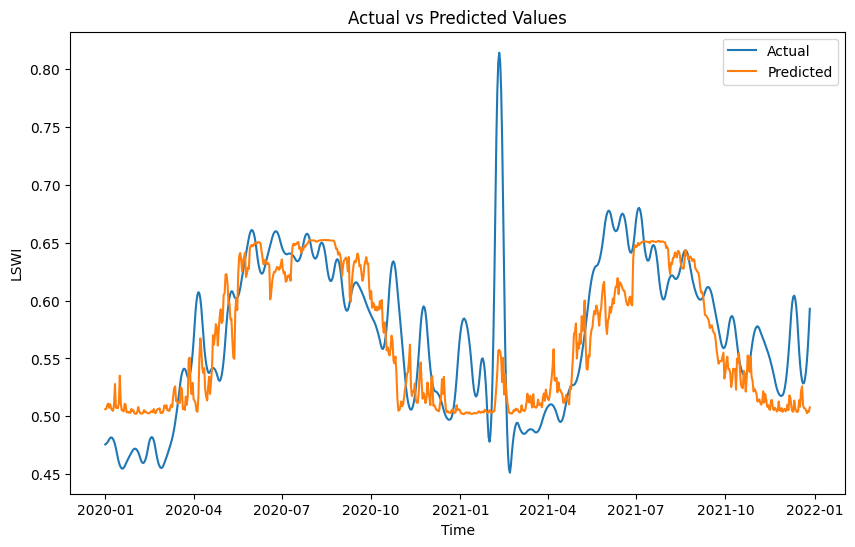

In [ ]:
index_test = test.index

plt.figure(figsize=(10, 6))
plt.plot(index_test, Ytest, label='Actual')
plt.plot(index_test, lswipred, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('LSWI')
plt.legend()
plt.show()

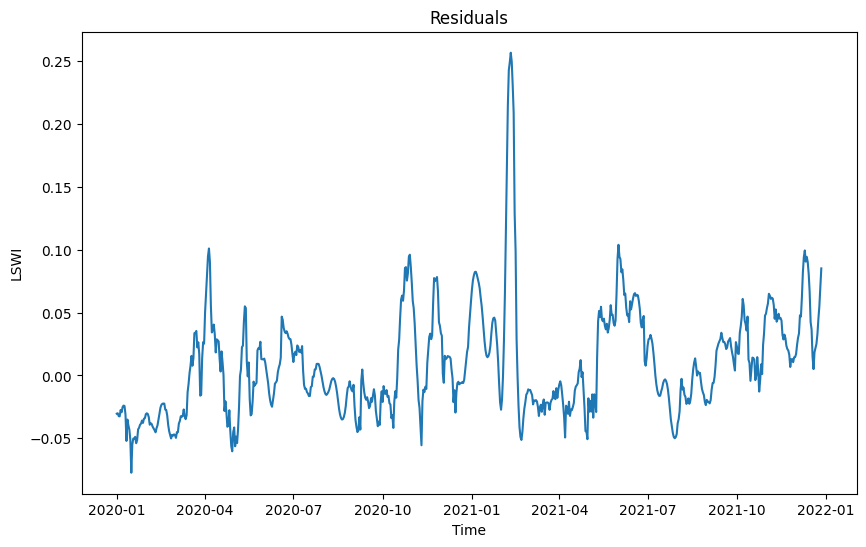

In [ ]:
resid = Ytest - lswipred

plt.figure(figsize=(10, 6))
plt.plot(index_test, resid)
plt.title('Residuals')
plt.xlabel('Time')
plt.ylabel('LSWI')
plt.show()

## Trying to add different layers

In [ ]:
from keras.layers import Dropout

learning_rate = 0.01
n_neurons = 50
n_epochs = 20
act_func = "tanh" #"softmax"
reg_term = l2(0.01)

model = Sequential()

model.add(LSTM(units = n_neurons, input_shape=(1, 8), return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(units= 5, return_sequences = True))  # Second LSTM layer
#model.add(Dropout(0.04))
model.add(LSTM(units= 2))

model.add(Dense(units = 1, kernel_regularizer=reg_term)) #activation=act_func,

# Compile the model
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Print model summary
model.summary()

# Fit the model
model.fit(Xtrain, Ytrain, epochs=n_epochs, batch_size=32)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_61 (LSTM)              (None, 1, 50)             11800     
                                                                 
 dropout_20 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_62 (LSTM)              (None, 1, 5)              1120      
                                                                 
 lstm_63 (LSTM)              (None, 2)                 64        
                                                                 
 dense_20 (Dense)            (None, 1)                 3         
                                                                 
Total params: 12987 (50.73 KB)
Trainable params: 12987 (50.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
204/20

In [ ]:
lstm_train = pd.DataFrame(model.predict(Xtrain), columns=['LSWI_train'])

train_metrics = metrics(Ytrain, lstm_train)

print(tabulate(train_metrics))

204/204 [==============================] - 2s 2ms/step
----  ----------
MAE   0.0333452
MSE   0.00249673
RMSE  0.0499673
MAPE  7.29792
R2    0.506181
----  ----------


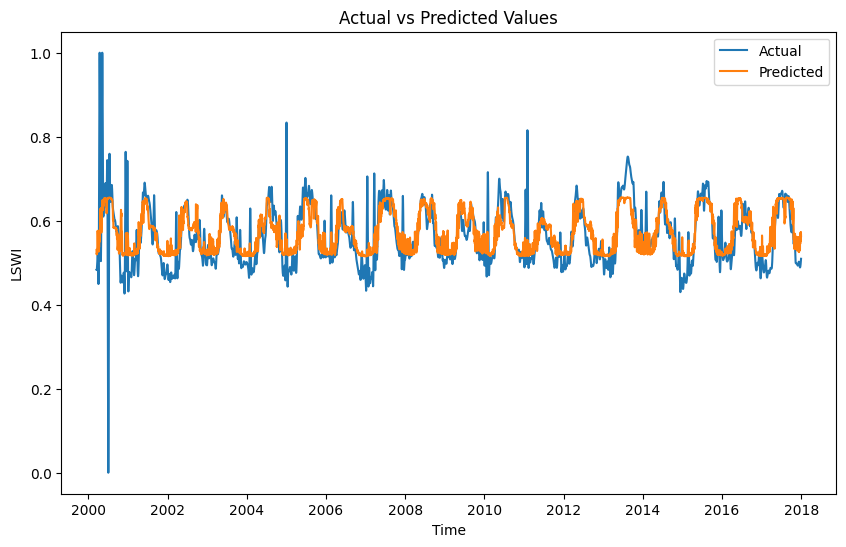

In [ ]:
index_train = training.index

plt.figure(figsize=(10, 6))
plt.plot(index_train, Ytrain, label='Actual')
plt.plot(index_train, lstm_train, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('LSWI')
plt.legend()
plt.show()

In [ ]:
lswipred = model.predict(Xtest)

lstm_pred = pd.DataFrame(lswipred, columns=['LSWI_pred'])

test_metrics = metrics(Ytest, lstm_pred)
#test_metrics
print(tabulate(test_metrics))

23/23 [==============================] - 0s 4ms/step
----  ----------
MAE   0.0318381
MSE   0.00183311
RMSE  0.0428148
MAPE  5.60311
R2    0.56901
----  ----------


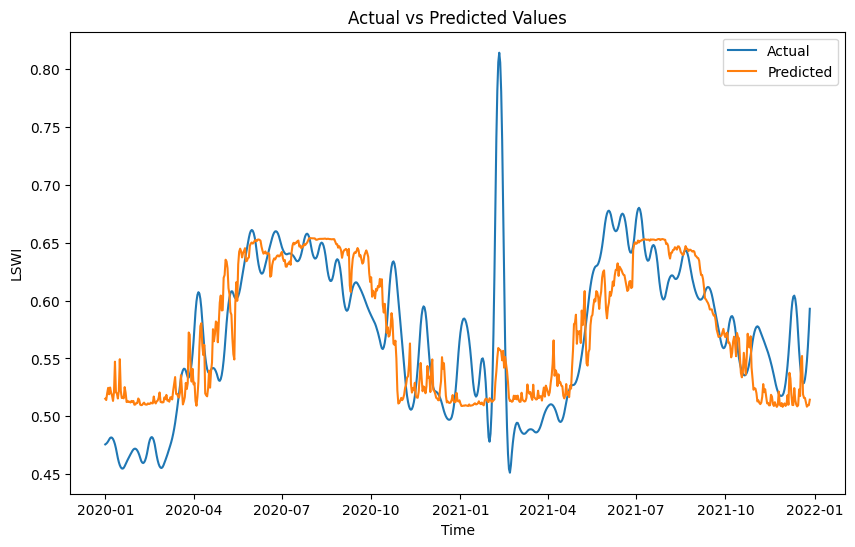

In [ ]:
index_test = test.index

plt.figure(figsize=(10, 6))
plt.plot(index_test, Ytest, label='Actual')
plt.plot(index_test, lswipred, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('LSWI')
plt.legend()
plt.show()